#分析鐵達尼生還關鍵因素

In [ ]:
#導入函數集
import numpy as np
import pandas as pd
import pandas.util.testing as tm
import pandas_profiling
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


In [ ]:
#導入數據並確認數據
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
'''
填補缺值
'''
#建構缺失值的表格自訂函數---get_missing_values
#並使用函數分別查看訓練與測試缺失值數量分布
def get_missing_values(df):
    #使用isnull找缺失值並以sum加總共缺幾個值
    #以缺失值大小遞增排序
    values = df.isnull().sum().sort_values()
    #使用DataFrame建構表格
    data = pd.DataFrame(values, columns=['Total missing values'])
    #axis=1或columns按照指定索引中數值排序(預設為0,按照列中數值排序)
    data = data[data.values.sum(axis=1) > 0]

    return data
    
print(get_missing_values(train_data))
print(get_missing_values(test_data))

          Total missing values
Embarked                     2
Age                        177
Cabin                      687
       Total missing values
Fare                      1
Age                      86
Cabin                   327


In [ ]:
#合併訓練與測試資料一起填補缺失值
#step1:合併資料並查看
combined_df = train_data.append(test_data, ignore_index=True, sort=True)#忽略舊的index欄位,並排序
get_missing_values(combined_df)

,Total missing values
Fare,1
Embarked,2
Age,263
Survived,418
Cabin,1014


In [ ]:
#一一查看缺失值細項並用不同方式填值
#1:Embarked出發地
#建構顯示細項的表格自訂函數---values
def values(df, feature_name):
    return pd.DataFrame(df[feature_name].value_counts(dropna=False))
values(combined_df, 'Embarked')
#僅有2筆缺失值,可使用眾數填補(也就是S)

,Embarked
S,914
C,270
Q,123
NaN,2


In [ ]:
#查看缺失Embarked的資料詳情並填補
combined_df[combined_df['Embarked'].isnull()] #查看
combined_df['Embarked'].fillna('S', inplace=True) 
#使用fillna(value='填補值')填補
#inplace為是否在原資料上操作,True則以新資料替換舊資料(預設為False)

In [ ]:
#2:Fare票價
#查看缺失Fare的資料詳情並填補
combined_df[combined_df['Fare'].isnull()]
#僅有1筆缺失值,以均值填補
#step1:查看各出發地不同艙等/性別下的票價均值
combined_df.groupby(['Embarked', 'Pclass', 'Sex'])['Fare'].mean()

Embarked  Pclass  Sex   
C         1       female    118.895949
                  male       94.622560
          2       female     27.003791
                  male       20.904406
          3       female     13.834545
                  male        9.775901
Q         1       female     90.000000
                  male       90.000000
          2       female     12.350000
                  male       11.489160
          3       female      9.791968
                  male       10.979167
S         1       female    100.475648
                  male       53.670756
          2       female     23.023118
                  male       20.073322
          3       female     18.083851
                  male       13.145977
Name: Fare, dtype: float64

In [ ]:
#續補值
#2:Fare票價
#step2:缺失值特徵為在S上船搭乘P3艙等的男性,均值13.14
combined_df['Fare'].fillna(13.14, inplace=True)

In [ ]:
#3:Cabin機艙位
combined_df[combined_df["Cabin"].notnull()]
#查看內容
#開頭皆為不同類別的字母,意義為deck(甲板位置)可以此分類

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
10,4.0,G6,S,16.7000,"Sandstrom, Miss. Marguerite Rut",1,11,3,female,1,1.0,PP 9549
11,58.0,C103,S,26.5500,"Bonnell, Miss. Elizabeth",0,12,1,female,0,1.0,113783
...,...,...,...,...,...,...,...,...,...,...,...,...
1295,43.0,D40,C,27.7208,"Frauenthal, Mr. Isaac Gerald",0,1296,1,male,1,NaN,17765
1296,20.0,D38,C,13.8625,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",0,1297,2,male,0,NaN,SC/PARIS 2166
1298,50.0,C80,C,211.5000,"Widener, Mr. George Dunton",1,1299,1,male,1,NaN,113503
1302,37.0,C78,Q,90.0000,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,1303,1,female,1,NaN,19928


In [ ]:
#以Cabin特徵定義Deck
combined_df['Deck'] = combined_df['Cabin'].str[:1]
combined_df[combined_df["Deck"].notnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,C
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,E
10,4.0,G6,S,16.7000,"Sandstrom, Miss. Marguerite Rut",1,11,3,female,1,1.0,PP 9549,G
11,58.0,C103,S,26.5500,"Bonnell, Miss. Elizabeth",0,12,1,female,0,1.0,113783,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,43.0,D40,C,27.7208,"Frauenthal, Mr. Isaac Gerald",0,1296,1,male,1,NaN,17765,D
1296,20.0,D38,C,13.8625,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",0,1297,2,male,0,NaN,SC/PARIS 2166,D
1298,50.0,C80,C,211.5000,"Widener, Mr. George Dunton",1,1299,1,male,1,NaN,113503,C
1302,37.0,C78,Q,90.0000,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,1303,1,female,1,NaN,19928,C


In [ ]:
#將缺失值的Deck資料設為M
combined_df['Deck'].fillna('M', inplace=True)

In [ ]:
#以表格觀察缺失值數量
values(combined_df, 'Deck')
#Deck中缺失值很大,需要使用別的方法填值

,Deck
M,1014
C,94
B,65
D,46
E,41
A,22
F,21
G,5
T,1


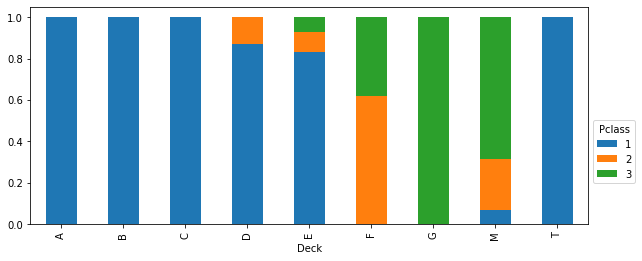

In [ ]:
#觀察艙等與甲板位置的分布關係
g = combined_df.groupby('Deck')['Pclass'].value_counts(normalize=True).unstack()
g.plot(kind='bar', stacked='True', figsize=(10,4) ).legend(bbox_to_anchor=(1, 0.5), title="Pclass")
#可觀察出1艙等的乘客多集中在A/B/C甲板
#3等艙乘客多集中在F/G/M甲板(而G甲板內只有3等艙乘客)

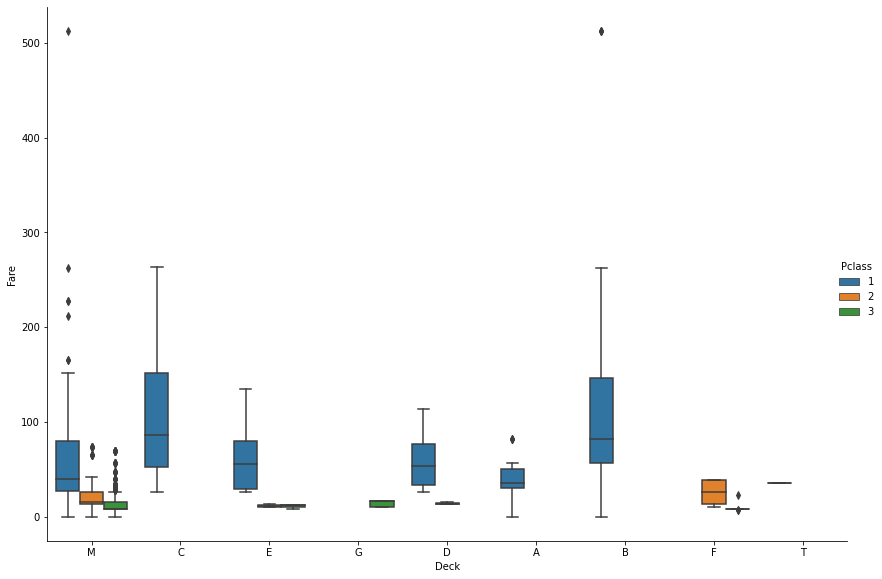

In [ ]:
#票價/艙等/甲板分布一起觀察
g = sns.catplot(y='Fare', x='Deck', hue='Pclass', data=combined_df, kind='box', height=10, aspect=2)
g.fig.set_figwidth(12)
g.fig.set_figheight(8)

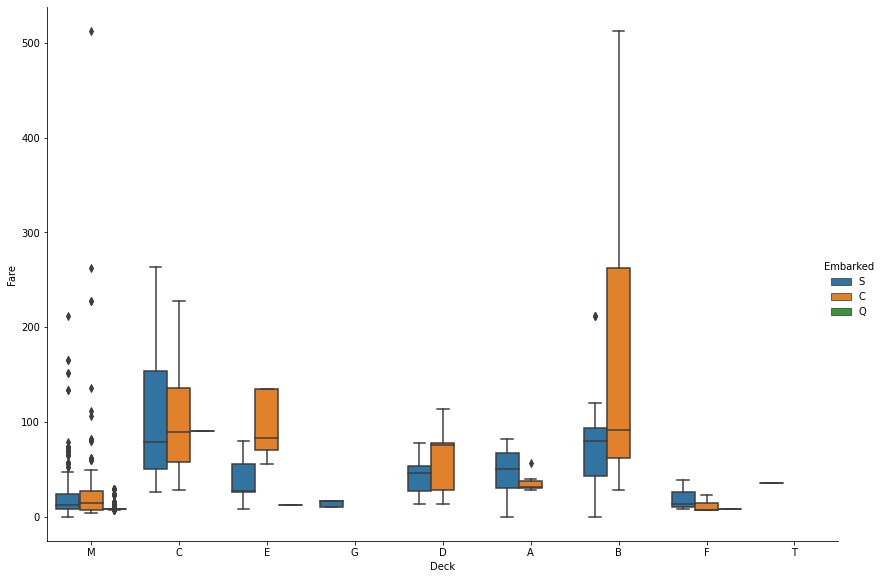

In [ ]:
#票價/出發地/甲板分布一起觀察
g = sns.catplot(y='Fare', x='Deck', hue='Embarked', data=combined_df, kind='box', height=10, aspect=2)
g.fig.set_figwidth(12)
g.fig.set_figheight(8)

#可觀察出有明顯的差別分布狀況,藉由這幾個變數很有機會清楚的推斷甲板位置

In [ ]:
#手動設立篩選條件並 顯示各艙等的甲板位置人數分布的均值
print(' ---- Pclass 1 ---- ')
print(' ** Embarked : S ** ')
print(combined_df[(combined_df['Pclass']==1) & (combined_df['Embarked']=='S') & (combined_df['Deck']!='M')].groupby(['Deck'])['Fare'].mean().sort_values())
print('')
print(' ** Embarked : C ** ')
print(combined_df[(combined_df['Pclass']==1) & (combined_df['Embarked']=='C') & (combined_df['Deck']!='M')].groupby(['Deck'])['Fare'].mean().sort_values())
print('')
print(' ** Embarked : Q ** ')
print(combined_df[(combined_df['Pclass']==1) & (combined_df['Embarked']=='Q') & (combined_df['Deck']!='M')].groupby(['Deck'])['Fare'].mean().sort_values())
print('')
print('')
print(' ---- Pclass 2 ---- ')
print(' ** Embarked : S ** ')
print(combined_df[(combined_df['Pclass']==2) & (combined_df['Embarked']=='S') & (combined_df['Deck']!='M')].groupby(['Deck'])['Fare'].mean().sort_values())
print('')
print(' ** Embarked : C ** ')
print(combined_df[(combined_df['Pclass']==2) & (combined_df['Embarked']=='C') & (combined_df['Deck']!='M')].groupby(['Deck'])['Fare'].mean().sort_values())
print('')
print(' ** Embarked : Q ** ')
print(combined_df[(combined_df['Pclass']==2) & (combined_df['Embarked']=='Q') & (combined_df['Deck']!='M')].groupby(['Deck'])['Fare'].mean().sort_values())
print('')
print('')
print(' ---- Pclass 3 ---- ')
print('** Embarked : S ** ')
print(combined_df[(combined_df['Pclass']==3) & (combined_df['Embarked']=='S') & (combined_df['Deck']!='M')].groupby(['Deck'])['Fare'].mean().sort_values())
print('')
print(' ** Embarked : C ** ')
print(combined_df[(combined_df['Pclass']==3) & (combined_df['Embarked']=='C') & (combined_df['Deck']!='M')].groupby(['Deck'])['Fare'].mean().sort_values())
print('')
print(' ** Embarked : Q ** ')
print(combined_df[(combined_df['Pclass']==3) & (combined_df['Embarked']=='Q') & (combined_df['Deck']!='M')].groupby(['Deck'])['Fare'].mean().sort_values())

 ---- Pclass 1 ---- 
 ** Embarked : S ** 
Deck
T     35.500000
E     46.435326
A     47.279155
D     47.707292
B     78.671088
C    110.369588
Name: Fare, dtype: float64

 ** Embarked : C ** 
Deck
A     35.209473
D     75.736725
E     99.071591
C    106.259044
B    167.461069
Name: Fare, dtype: float64

 ** Embarked : Q ** 
Deck
C    90.0
Name: Fare, dtype: float64


 ---- Pclass 2 ---- 
 ** Embarked : S ** 
Deck
E    11.333333
D    13.000000
F    23.423077
Name: Fare, dtype: float64

 ** Embarked : C ** 
Deck
D    13.89375
Name: Fare, dtype: float64

 ** Embarked : Q ** 
Deck
E    12.35
Name: Fare, dtype: float64


 ---- Pclass 3 ---- 
** Embarked : S ** 
Deck
F     7.650
E    11.000
G    14.205
Name: Fare, dtype: float64

 ** Embarked : C ** 
Deck
F    12.272233
Name: Fare, dtype: float64

 ** Embarked : Q ** 
Deck
F    7.75
Name: Fare, dtype: float64


In [ ]:
#定義一個函數填補缺失值(使用list篩選並填均值)
def fill_deck(df):
    temp = []
    temp_deck = ''
    #由上述艙等>出發地>票價填補甲板位置
    for idx in range(len(df)):
        temp_deck = df.iloc[idx]['Deck']
        if df.iloc[idx]['Deck'] == 'M':
            if df['Pclass'].iloc[idx] == 1:
                if df['Embarked'].iloc[idx] == 'S':
                    if df['Fare'].iloc[idx] < 35.5:
                        temp_deck = 'T'

                    elif df['Fare'].iloc[idx] >= 35.50 and df['Fare'].iloc[idx] < 46.43:
                        temp_deck = 'E'

                    elif df['Fare'].iloc[idx] >= 46.43 and df['Fare'].iloc[idx] < 47.27:
                        temp_deck = 'A'

                    elif df['Fare'].iloc[idx] >= 47.27 and df['Fare'].iloc[idx] < 47.70:
                        temp_deck = 'D'

                    elif df['Fare'].iloc[idx] >= 47.70 and df['Fare'].iloc[idx] < 78.67:
                        temp_deck = 'B'

                    else:
                        temp_deck = 'C'

                elif df['Embarked'].iloc[idx] == 'C':
                    if df['Fare'].iloc[idx] < 35.20:
                        temp_deck = 'A'

                    elif df['Fare'].iloc[idx] >= 35.20 and df['Fare'].iloc[idx] < 75.73:
                        temp_deck = 'D'

                    elif df['Fare'].iloc[idx] >= 75.73 and df['Fare'].iloc[idx] < 99.07:
                        temp_deck = 'E'

                    elif df['Fare'].iloc[idx] >= 99.07 and df['Fare'].iloc[idx] < 106.25:
                        temp_deck = 'C'

                    else:
                        temp_deck = 'B'

                elif df['Embarked'].iloc[idx] == 'Q':
                    temp_deck = 'C'

            elif df['Pclass'].iloc[idx] == 2:
                if df['Embarked'].iloc[idx] == 'S':
                    if df['Fare'].iloc[idx] < 11.33:
                        temp_deck = 'E'

                    elif df['Fare'].iloc[idx] >= 11.33 and df['Fare'].iloc[idx] < 13:
                        temp_deck = 'D'

                    else:
                        temp_deck = 'F'

                elif df['Embarked'].iloc[idx] == 'C':
                    temp_deck = 'D'

                elif df['Embarked'].iloc[idx] == 'Q':
                    temp_deck = 'E'

            elif df['Pclass'].iloc[idx] == 3:
                if df['Embarked'].iloc[idx] == 'S':
                    if df['Fare'].iloc[idx] < 7.60:
                        temp_deck = 'F'

                    elif df['Fare'].iloc[idx] >= 7.60 and df['Fare'].iloc[idx] < 11:
                        temp_deck = 'E'

                    else:
                        temp_deck = 'G'

                else:
                    temp_deck = 'F'

        temp.append(temp_deck)
    df['Deck'] = temp


fill_deck(combined_df) 

In [ ]:
#4:Age年齡
#一開始的表格顯示有263個缺失值
#年齡若使用均值填補,會有失準確度 (票價均值的意義為區段區分,年齡則會造成大偏誤)
#查看相關資訊以用更好的方式填值
combined_df["Name"].to_list()[:30]
#是否可用稱謂判斷年齡

['Braund, Mr. Owen Harris',
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
 'Heikkinen, Miss. Laina',
 'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
 'Allen, Mr. William Henry',
 'Moran, Mr. James',
 'McCarthy, Mr. Timothy J',
 'Palsson, Master. Gosta Leonard',
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
 'Nasser, Mrs. Nicholas (Adele Achem)',
 'Sandstrom, Miss. Marguerite Rut',
 'Bonnell, Miss. Elizabeth',
 'Saundercock, Mr. William Henry',
 'Andersson, Mr. Anders Johan',
 'Vestrom, Miss. Hulda Amanda Adolfina',
 'Hewlett, Mrs. (Mary D Kingcome) ',
 'Rice, Master. Eugene',
 'Williams, Mr. Charles Eugene',
 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
 'Masselmani, Mrs. Fatima',
 'Fynney, Mr. Joseph J',
 'Beesley, Mr. Lawrence',
 'McGowan, Miss. Anna "Annie"',
 'Sloper, Mr. William Thompson',
 'Palsson, Miss. Torborg Danira',
 'Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)',
 'Emir, Mr. Farred Chehab',
 'Fortune, Mr. Charles Alexander',
 '

In [ ]:
#增加稱號欄位方便未來判斷年齡 
combined_df['Title'] = ''
for _ in combined_df:
    combined_df['Title'] = combined_df['Name'].str.extract('([A-Za-z]+)\.')
 #使用str.extract取第一個找到的值,同時以上面的訊可觀察出稱謂皆以'.'結尾,由於順序關係只會取到稱謂

combined_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,F,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,E,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,C,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,E,Mr


In [ ]:
#概覽稱謂分布
pd.crosstab(combined_df["Title"], combined_df["Sex"]).T
#可看出有四大種稱謂為大宗

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [ ]:
#清除極端值
#除了Master,Miss,Mr,Mrs(還有近義詞 Lady,Mlle,Mme,Ms)外皆以Rare替代
combined_df["Title"].replace(
    ['Capt', 'Col','Countess','Don', 'Dona', 'Dr', 'Jonkheer', 'Major', 'Rev', 'Sir', 'Dona'], 'Rare'
, inplace = True)

In [ ]:
#查看稱謂與生還率的關係
#填補 Lady,Mlle,Mme,Ms
combined_df['Title'].replace(
    ['Lady', 'Mlle', 'Mme', 'Ms'],
    ['Mrs', 'Miss', 'Miss', 'Mrs'],inplace=True)
pd.crosstab(combined_df["Title"], combined_df["Survived"]).T

Title,Master,Miss,Mr,Mrs,Rare
Survived,,,,,
0.0,17,55,436,26,15
1.0,23,130,81,101,7


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


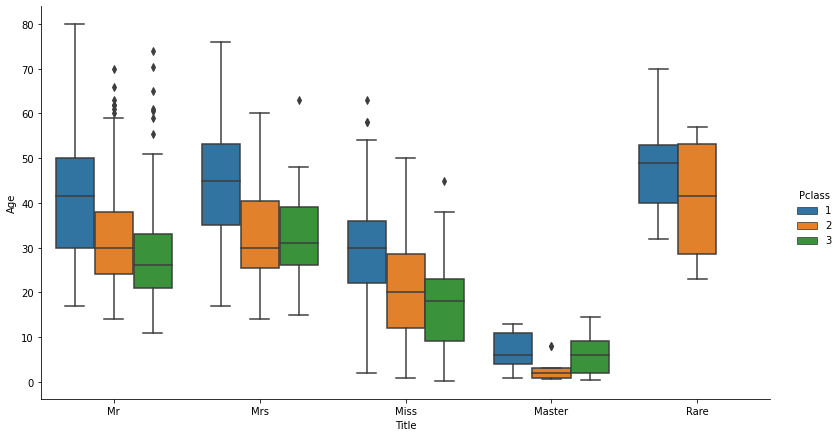

In [ ]:
#查看年齡與艙等分布
g = sns.catplot(y="Age",x="Title",hue="Pclass", data=combined_df, kind="box", size = 8)
g.fig.set_figwidth(12)
g.fig.set_figheight(6)

In [ ]:
#使用describe敘述統計
combined_df.groupby(["Title", "Pclass"])["Age"].describe() 

count       mean        std    min     25%   50%    75%   max
Title  Pclass                                                               
Master 1         5.0   6.984000   4.974061   0.92   4.000   6.0  11.00  13.0
       2        11.0   2.757273   2.723942   0.67   0.915   2.0   3.00   8.0
       3        37.0   6.090000   4.152566   0.33   2.000   6.0   9.00  14.5
Miss   1        62.0  30.032258  11.460506   2.00  22.000  30.0  36.00  63.0
       2        48.0  20.717083  12.207963   0.92  12.000  20.0  28.50  50.0
       3       103.0  17.360874   9.935434   0.17   9.000  18.0  23.00  45.0
Mr     1       132.0  41.450758  13.489020  17.00  30.000  41.5  50.00  80.0
       2       137.0  32.346715  11.862038  14.00  24.000  30.0  38.00  70.0
       3       312.0  28.318910   9.907858  11.00  21.000  26.0  33.00  74.0
Mrs    1        68.0  43.279412  13.941076  17.00  35.000  45.0  53.25  76.0
       2        55.0  33.418182  10.422005  14.00  25.500  30.0  40.50  60.0
       3        49.0  32.326531  10.194745  15.00  26.000  31.0  39.00  63.0
Rare   1        17.0  47.647059   9.727160  32.00  40.000  49.0  53.00  70.0
       2        10.0  40.700000  12.927576  23.00  28.500  41.5  53.25  57.0

In [ ]:
#為何使用第三百分位填補年齡??????
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Master') & (combined_df['Pclass']==1),'Age'] = 11
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Master') & (combined_df['Pclass']==2),'Age'] = 3
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Master') & (combined_df['Pclass']==3),'Age'] = 9

combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Miss') & (combined_df['Pclass']==1),'Age'] = 36
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Miss') & (combined_df['Pclass']==2),'Age'] = 28.5
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Miss') & (combined_df['Pclass']==3),'Age'] = 23

combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Mr') & (combined_df['Pclass']==1),'Age'] = 50
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Mr') & (combined_df['Pclass']==2),'Age'] = 38
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Mr') & (combined_df['Pclass']==3),'Age'] = 33

combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Mrs') & (combined_df['Pclass']==1),'Age'] = 53.25
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Mrs') & (combined_df['Pclass']==2),'Age'] = 40.5
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Mrs') & (combined_df['Pclass']==3),'Age'] = 39

combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Rare') & (combined_df['Pclass']==1),'Age'] = 53
combined_df.loc[(combined_df['Age'].isnull()) & (combined_df['Title']=='Rare') & (combined_df['Pclass']==2),'Age'] = 53.25

Text(0.5, 1.0, 'Gender Distribution - Survived vs Not-survived')

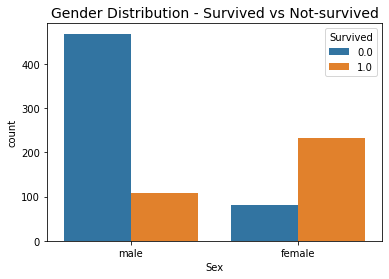

In [ ]:
'''
觀察特徵(與倖存關聯性高的變數)

'''
#gender:
data = combined_df.loc[combined_df['Survived'].notnull()]
sns.countplot(x='Sex', hue='Survived', data = data)
plt.title('Gender Distribution - Survived vs Not-survived', fontsize = 14)
#女性生還率明顯高於男性,可做為特徵

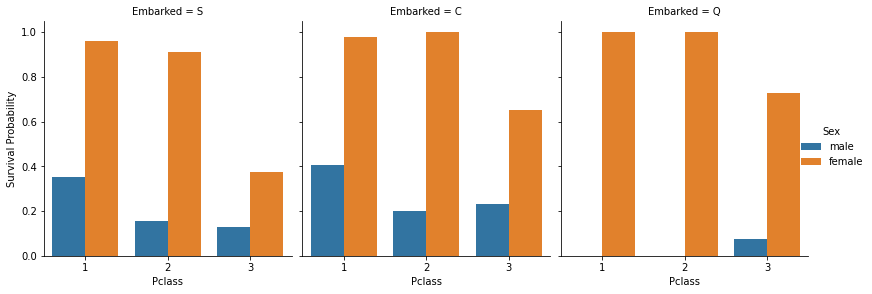

In [ ]:
#使用不同出發地分析性別是否為一個顯著的特徵
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=data, kind='bar', ci=None, col='Embarked')
g = g.set_ylabels('Survival Probability')
g.fig.set_figwidth(12)
g.fig.set_figheight(4)
#不論何處出發,女性皆有較高的生還率
#疑問:由Q出發為何沒有1/2艙男性生還

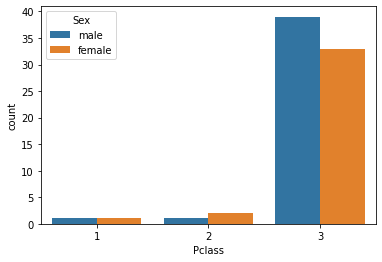

In [ ]:
#展開Q地出發的資料
sns.countplot(x='Pclass', hue='Sex', data=data[data['Embarked']=='Q'])
#在Q地登船的1/2艙乘客很少,(樣本個體小)沒有男性存活無法作為異常情況的推斷,表示性別能作為良好的特徵

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


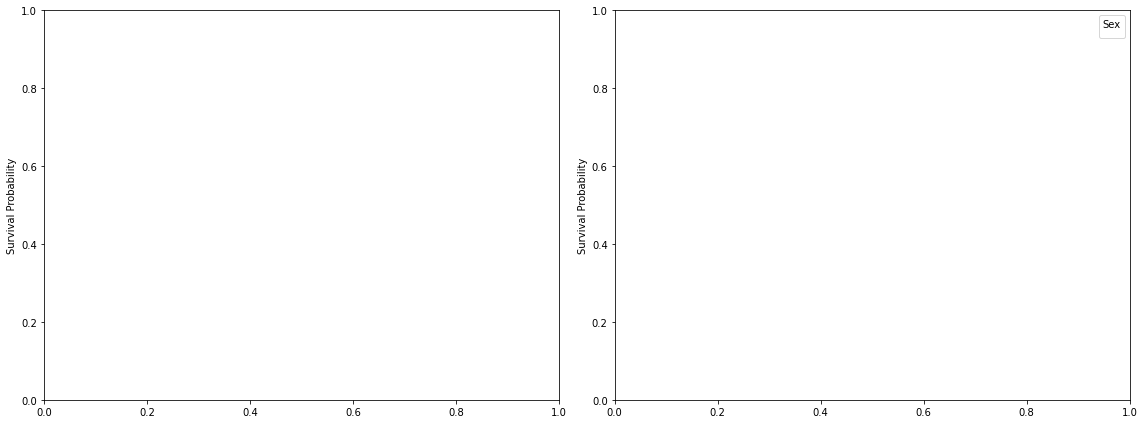

In [ ]:
#P Class:
fig, ax = plt.subplots(1 ,2, figsize=(16,6))
sns.catplot(x='Pclass', y='Survived', data=data, kind='bar', ci=None, ax=ax[0])
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=data, kind='point', ci=None, ax=ax[1])

for i in range(2):
    ax[i].set_ylabel('Survival Probability')

ax[1].legend(loc='upper right', title='Sex')

plt.close(2)
plt.close(3)

fig.tight_layout()
plt.show()
#不論性別艙等越高級,生還人數越高
#女性生還人數仍遠高各艙等的男性

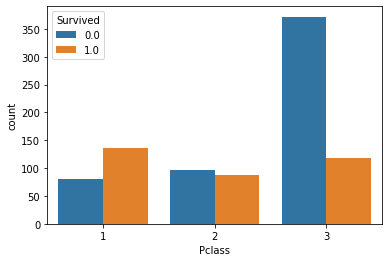

In [ ]:
#觀察各艙等詳細的生還與死亡人數(以生還率推斷艙等是否一個好的特徵)
g = sns.countplot(x='Pclass', hue='Survived', data=data)
#結果顯示艙等越高生還率越高,為顯著的特徵

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try violinplot
  warnings.warn(msg, UserWarning)


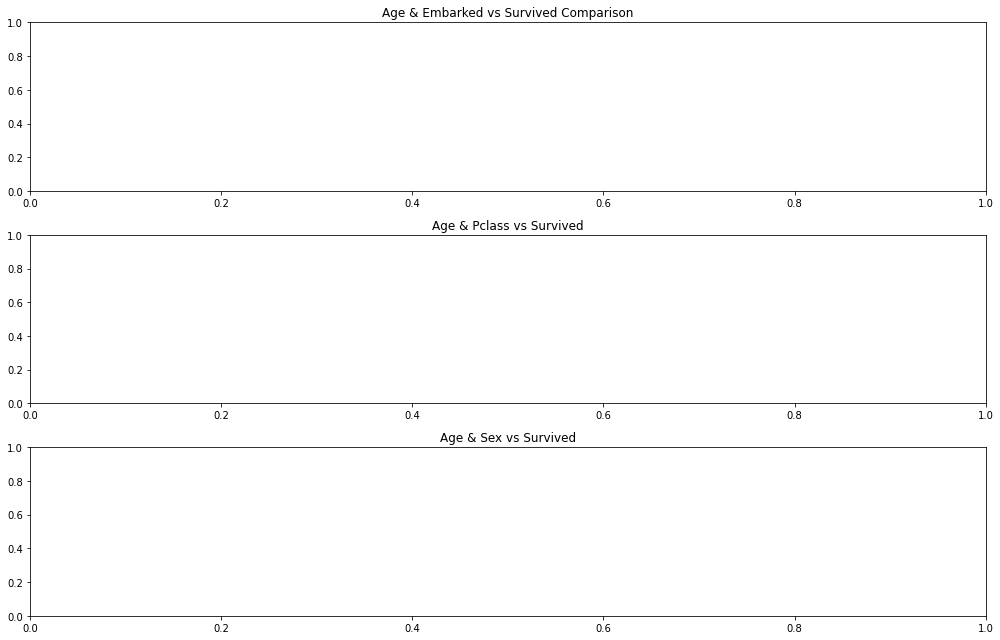

In [ ]:
#Age:
fig, ax = plt.subplots(3 ,1,figsize=(14,9))
sns.catplot(x='Age', y='Embarked', hue='Survived', data=data, orient='h', 
            kind='violin', dodge=True, cut=0, bw='scott', split = True, ax = ax[0])
ax[0].set_title('Age & Embarked vs Survived Comparison')

#由各出發地分析年齡層存活率
#Q地出發生還者多為青少年與青壯年15-25歲
#S與C地出發生還者多為幼童(幼童死者比例低)

sns.catplot(x='Age', y='Pclass', hue='Survived', data=data, orient='h', 
            kind='violin', dodge=True, cut=0, bw="scott", split = True, ax = ax[1])
ax[1].set_title('Age & Pclass vs Survived')

#由艙等分析年齡層存活率
#各艙等的幼兒存活比率都很高

sns.catplot(x='Age', y='Sex', hue='Survived', data=data, orient='h', 
            kind='violin', dodge=True, cut=0, bw='scott', split = True, ax = ax[2])
ax[2].set_title('Age & Sex vs Survived')
#由性別分析年齡層存活率
#男性幼兒存活比率高於女性幼兒,而50歲以上女性存活比率高於男性

plt.close(2)
plt.close(3)
plt.close(4)
fig.tight_layout()
plt.show()

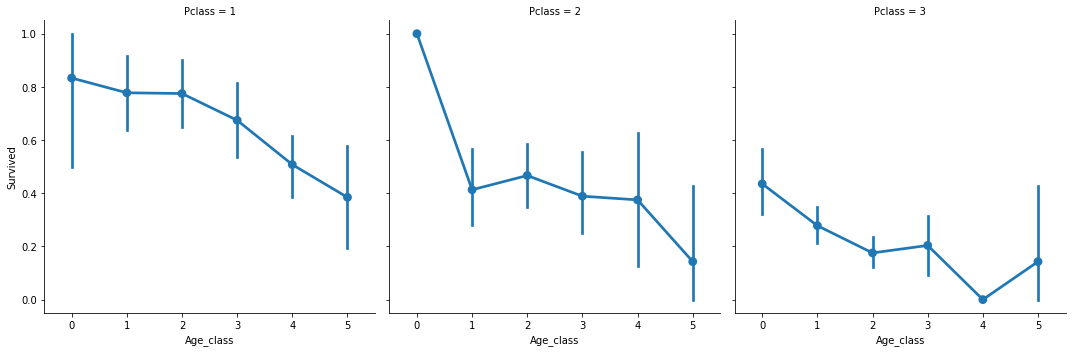

In [ ]:
#各艙等與年齡皆有顯著特徵,將數據以艙等切割成小段分析
combined_df['Age_class'] = ''
combined_df.loc[combined_df['Age'] <= 15, 'Age_class'] = 0 #各艙等與年齡皆有顯著特徵,將數據以艙等切割成小段分析
combined_df.loc[(combined_df['Age'] > 15) & (combined_df['Age'] <= 25), 'Age_class'] = 1
combined_df.loc[(combined_df['Age'] > 25) & (combined_df['Age'] <= 35), 'Age_class'] = 2
combined_df.loc[(combined_df['Age'] > 35) & (combined_df['Age'] <= 45), 'Age_class'] = 3
combined_df.loc[(combined_df['Age'] > 45) & (combined_df['Age'] <= 55), 'Age_class'] = 4
combined_df.loc[combined_df['Age'] > 55, 'Age_class'] = 5

sns.catplot('Age_class','Survived', data=combined_df, col='Pclass', kind='point' )
plt.show()
#各艙等的15歲下幼童有最高的存活率
#各艙等都具有年齡越大存活率越低的情況,年齡可能是一個好的特徵

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


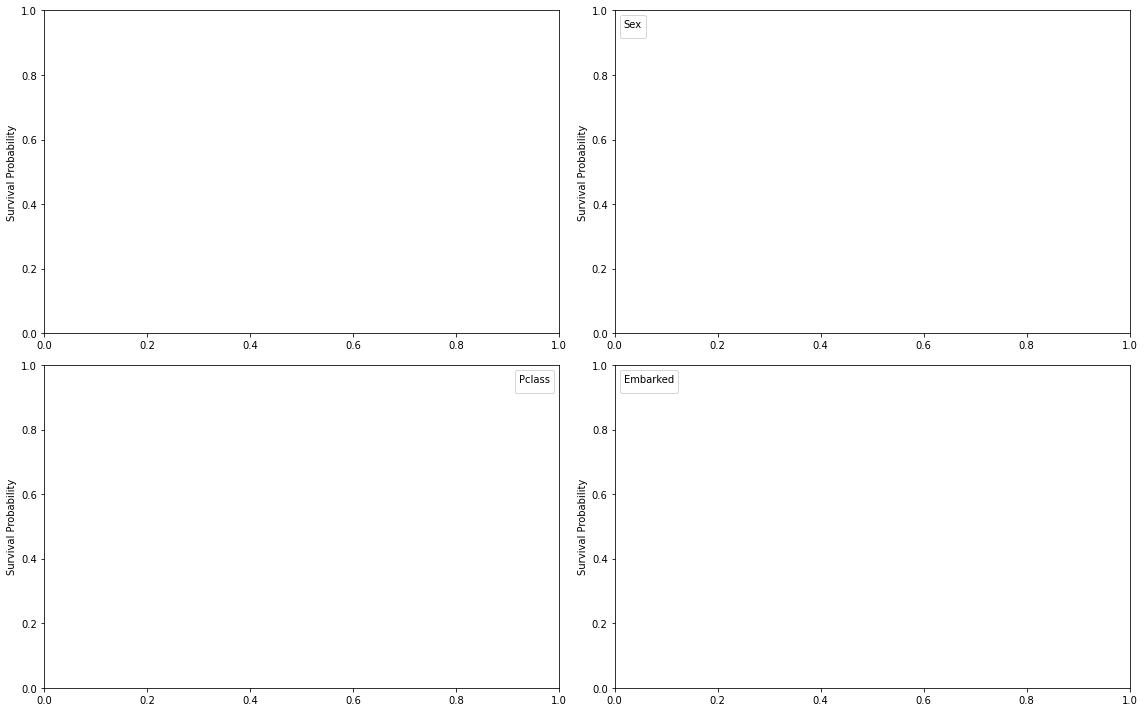

In [ ]:
#Deck:
data = combined_df[combined_df["Survived"].notnull()]
fig, ax = plt.subplots(2 ,2, figsize=(16,10))
#查看甲板位置與生還率的關係(B/C/D甲板生還率特別高,甲板位置可能是顯著的特徵)
sns.catplot(x='Deck', y='Survived', data=data, kind='bar', ci=None, ax=ax[0,0])
#查看甲板不同性別生還的比率(各甲板女性生還率皆遠高過男性,A/B/D甲板甚至有100%的生還率)
sns.catplot(x='Deck', y='Survived', hue='Sex', data=data, kind='bar', ci=None, ax=ax[0,1])
#1與2艙等的乘客生還率明顯高於3艙乘客生還率
sns.catplot(x='Deck', y='Survived', hue='Pclass', data=data, kind='bar', ci=None, ax=ax[1,0])
#即使在同地點出發,B/C/D甲板仍有更高的生還率
sns.catplot(x='Deck', y='Survived', hue='Embarked', data=data, kind='bar', ci=None, ax=ax[1,1])

#建立生還機率????????為甚麼是range2==>左到右進行繪圖,i j為橫軸縱軸的概念~?
for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('Survival Probability')

ax[0,1].legend(loc='upper left', title='Sex')
ax[1,0].legend(loc='upper right', title='Pclass')
ax[1,1].legend(loc='upper left', title='Embarked')
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
fig.tight_layout()
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)


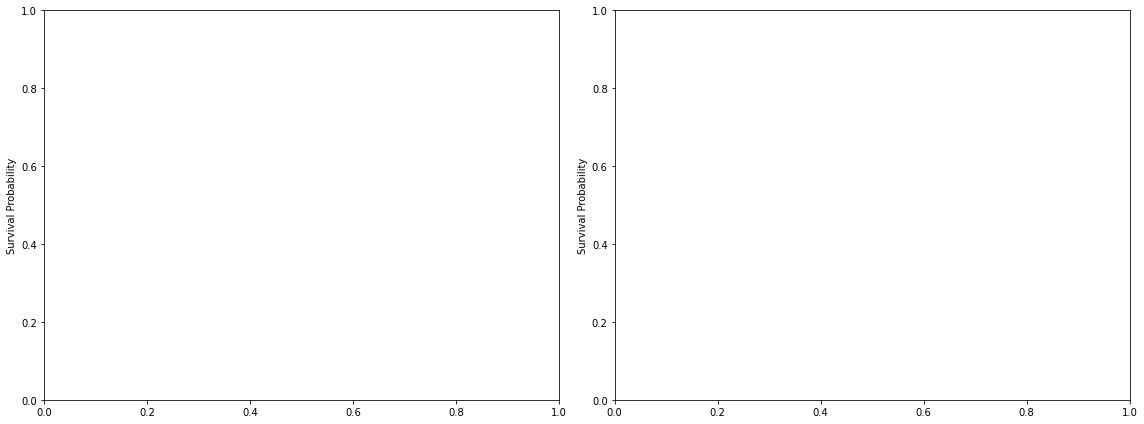

In [ ]:
#SibSp and Parch:
data = combined_df[combined_df["Survived"].notnull()]
fig, ax = plt.subplots(1 ,2, figsize=(16,6))
#查看兄弟姊妹數與生還率的關係,可以看到兄弟姊妹越多生還率呈現遞減
sns.catplot(x='SibSp', y='Survived', data=data, kind='point', ax=ax[0])
#查看家庭人數與生還率的關係,家庭人數為3的小家庭生還率最高
sns.catplot(x='Parch', y='Survived', data=data, kind='point', ax=ax[1])

for i in range(2):
    ax[i].set_ylabel('Survival Probability')

plt.close(2)
plt.close(3)
fig.tight_layout()
plt.show()

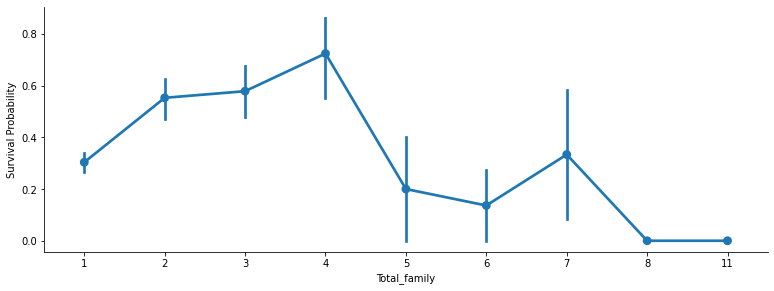

In [ ]:
#創建新變量 Total_family=Parch+SibSp
combined_df['Total_family'] = combined_df['Parch'] + combined_df['SibSp'] + 1
data = combined_df[combined_df['Survived'].notnull()]
g = sns.catplot(x='Total_family', y='Survived', data=data, kind='point')
g = g.set_ylabels('Survival Probability')
g.fig.set_figwidth(12)
g.fig.set_figheight(4)
#2/3/4人的家族生還率勝於1人旅行的乘客,獨自旅行的生還率又大於5人以上的家族

In [ ]:
#做類別分類並比較生還率
combined_df['Single'] = combined_df['Total_family'].map(lambda x: 1 if x==1 else 0) #使用lambda快速定義函式(語意閉包?)
combined_df['Small_family'] = combined_df['Total_family'].map(lambda x: 1 if 2 <= x <=4 else 0)
combined_df['Medium_family'] = combined_df['Total_family'].map(lambda x: 1 if 5 <= x <=7 else 0)
combined_df['Large_family'] = combined_df['Total_family'].map(lambda x: 1 if 7 < x else 0)
data = combined_df[combined_df['Survived'].notnull()]

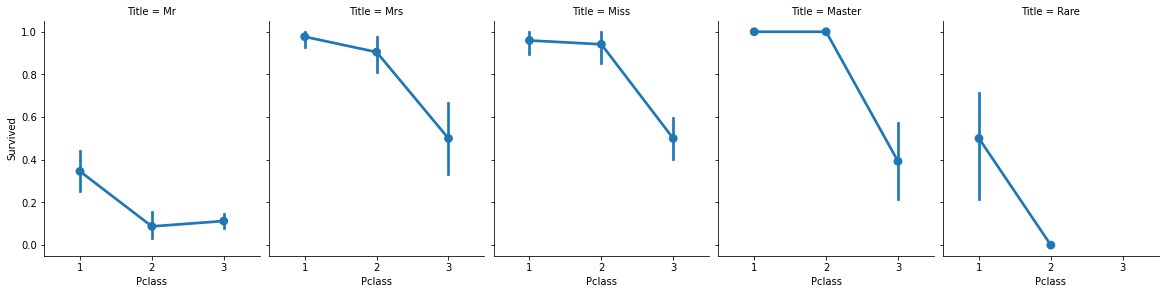

In [ ]:
#Title:
#1/2艙等的Master有100%的生還率,1艙等的Miss/Mrs也有接近100%的生還率
g = sns.catplot(x='Pclass',y='Survived', col='Title',data=data, kind='point')
g.fig.set_figwidth(16)
g.fig.set_figheight(4)

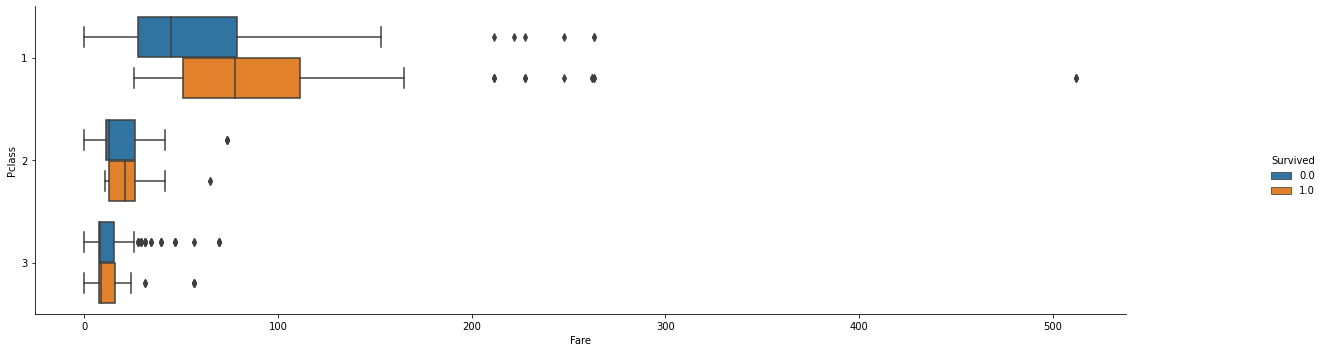

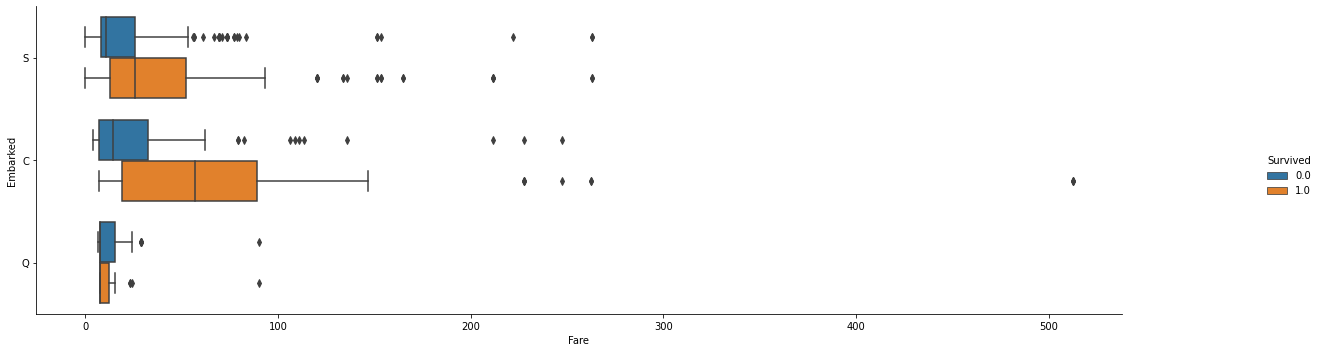

In [ ]:
#Fare:
#1艙等票價明顯高於2/3艙,生還率也高出許多 (2/3艙票價則沒有明顯的差距)
g1 = sns.catplot(x='Fare', y='Pclass', hue='Survived', data=data, kind='box', orient="h")
g1.fig.set_figwidth(20)
#Q地出發的票價較低,而C地的生還率最高
g2 = sns.catplot(x='Fare', y='Embarked', hue='Survived', data=data, kind='box', orient="h")
g2.fig.set_figwidth(20)

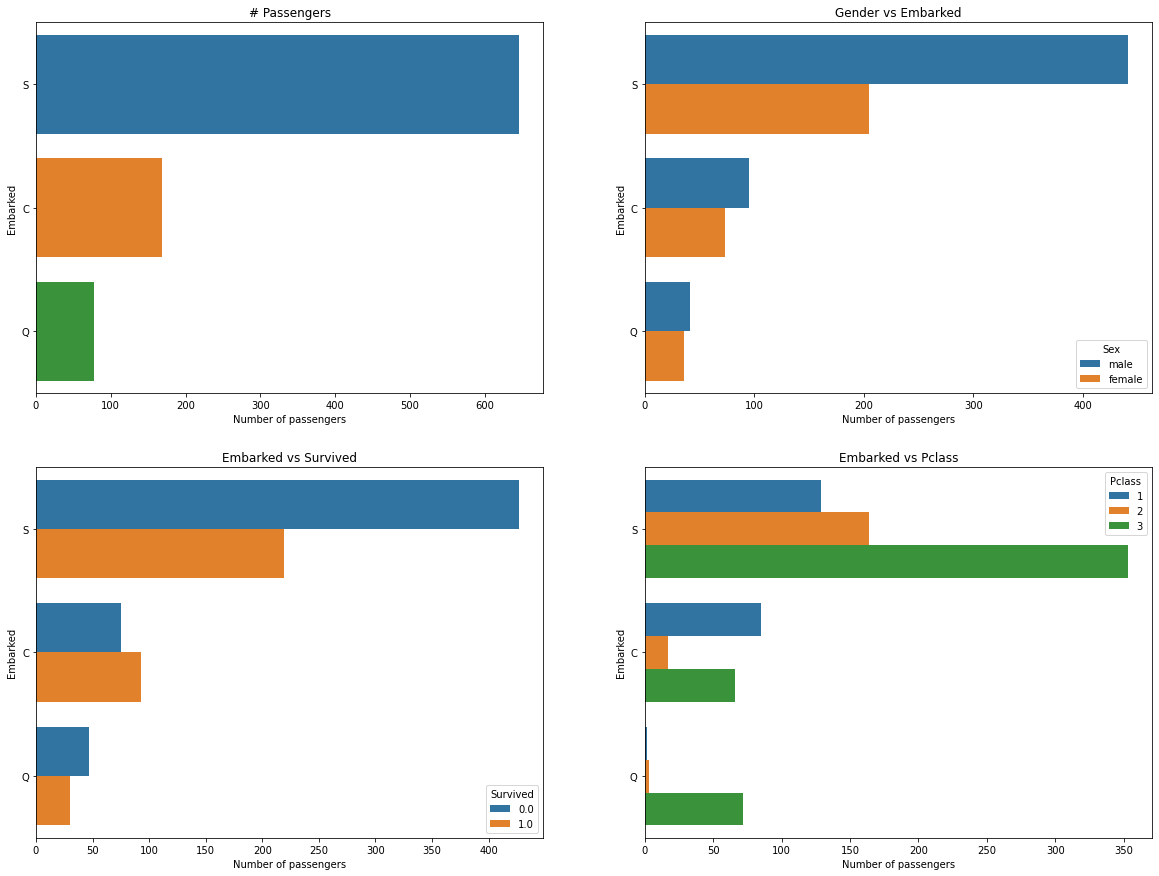

In [ ]:
#Embarked:
#大部分的人從S地出發
fig, ax = plt.subplots(2,2,figsize=(20,15))
sns.countplot(y='Embarked', data=data, ax=ax[0,0])
ax[0,0].set_title('# Passengers')
#而S地出發多為男性(人數約為2倍女性乘客)
sns.countplot(y='Embarked', hue='Sex', data=data, ax=ax[0,1])
ax[0,1].set_title('Gender vs Embarked')
#C地出發的生還率較高,S地較低(可能因為男性乘客很多,降低生還率)
sns.countplot(y='Embarked', hue='Survived', data=data, ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
#S地出發的以3倉乘客為主,也可能是造成生還率降低的原因
#C地出發的以1倉乘客為主,可能造成生還率上升
sns.countplot(y='Embarked', hue='Pclass', data=data, ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Number of passengers')

plt.show()

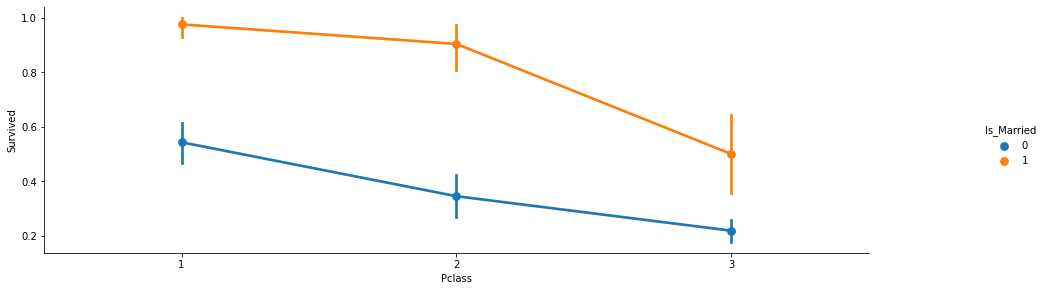

In [ ]:
#Married vs not married:
combined_df['Is_Married'] = 0
combined_df['Is_Married'] = combined_df['Title'].map(lambda x: 1 if x=='Mrs' else 0)#以Mrs作為已婚女性的判別索引

data = combined_df.loc[combined_df['Survived'].notnull()]
g = sns.catplot(x='Pclass',y='Survived', hue='Is_Married', data=data, kind='point')
g.fig.set_figwidth(16)
g.fig.set_figheight(4)
#可見各艙等內已婚女性的生還率都高於均值

In [ ]:
print(combined_df)
'''
網站中沒提供Fare_groups程式碼,執行後續get_dummies會ERROR
如下
'''

       Age Cabin Embarked  ...  Medium_family Large_family  Is_Married
0     22.0   NaN        S  ...              0            0           0
1     38.0   C85        C  ...              0            0           1
2     26.0   NaN        S  ...              0            0           0
3     35.0  C123        S  ...              0            0           1
4     35.0   NaN        S  ...              0            0           0
...    ...   ...      ...  ...            ...          ...         ...
1304  33.0   NaN        S  ...              0            0           0
1305  39.0  C105        C  ...              0            0           0
1306  38.5   NaN        S  ...              0            0           0
1307  33.0   NaN        S  ...              0            0           0
1308   9.0   NaN        C  ...              0            0           0

[1309 rows x 21 columns]


'\n網站中沒提供Fare_groups程式碼,執行後續get_dummies會ERROR\n如下\n'

In [ ]:
#先刪去用不到的特徵
combined_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Total_family', 'Age', 'Fare'], inplace=True)

#分割train & test data


In [ ]:
#分割訓練/測試資料
'''
並使用StandardScaler做標準化數據
StandardScaler
.fit_transfrom:
計算訓練集的平均值和標準差,並標準化數據(其標準化使用統計z-score的概念)

.fit:求出mean,var,max,min...來訓練資料
.transfrom:標準化/歸一化
'''
train = combined_df[combined_df['Survived'].isnull() == False]
predict = combined_df[combined_df['Survived'].isnull() == True]
predict = predict.drop(columns=['Survived'])
from sklearn.preprocessing import StandardScaler

X = train.drop(['Survived'], axis = 1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

std_sc = StandardScaler()

X_train = std_sc.fit_transform(X_train)
X_test = std_sc.transform(X_test)

#Transform 'submission dataset'
predict = std_sc.transform(predict)

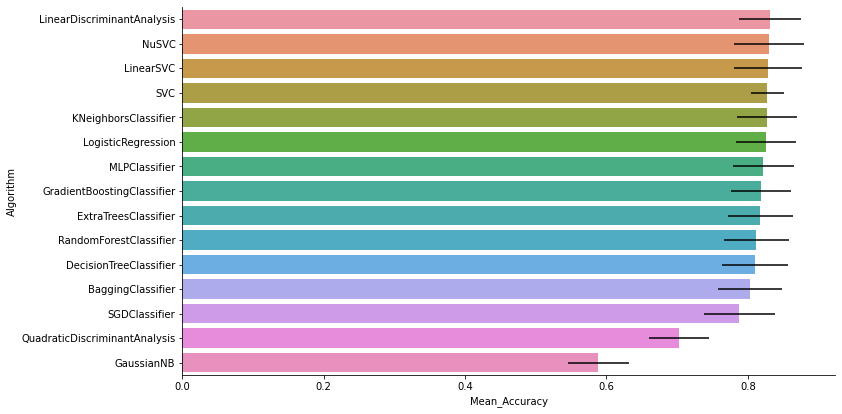

In [ ]:
#使用多種模型計算預測精確度並視覺化
'''
step1:
使用StratifiedKFold將資料分成10份
step2:
先創建classifiers的空字串,將使用sklearn套件中各種演算法訓練數據append進去

LinearSVC:支持向量分類的一種,線性SVM

QuadraticDiscriminantAnalysis:二次判別

DecisionTreeClassifier:決策樹

GaussianNB:高斯分布的貝氏,naive bayes模型的一種,主要分析特徵為數值型態的資料(且常態分布)

RandomForestClassifier:隨機森林

ExtraTreesClassifier:極限樹(更隨機)

GradientBoostingClassifier:梯度增加

MLPClassifier:類神經網路的一種

KNeighbors:近鄰演算法

LogisticRegression:邏輯回歸

LinearDiscriminantAnalysis:線性判別分析

BaggingClassifier:ensemble learning的其中一個方法
#ensemble learning為整合多個weak learner,可提高演算效率與降低成本?

SGDClassifier:隨機梯度下降

NuSVC:支持向量分類的一種,與SVC很像,但多了一個nu值控制錯誤率(介於0-1)

SVC:支持向量分類
step3:使用cross_val_score作交叉驗證
參數:(estimator:使用的演算法,x:feature,y:label,soring：評分方式,cv：進行幾折的交叉驗證,n_jobs:同時工作的cpu個數,-1為使用所有的cpu)
step4:製作一個DataFrame型態的表格放精準度相關資料
step5:視覺化上表
'''
kfold = StratifiedKFold(n_splits=10)

random_state = 42
classifiers = []

classifiers.append(LinearSVC(random_state=random_state))
classifiers.append(QuadraticDiscriminantAnalysis())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(GaussianNB())
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier(n_neighbors=20))
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SGDClassifier(loss='log', random_state=random_state))
classifiers.append(NuSVC(probability=True, random_state=random_state))
classifiers.append(SVC(kernel='linear', probability=True, random_state=random_state))

names = []
cv_results = []
for classifier in classifiers :
    names.append(classifier.__class__.__name__)
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = 'accuracy', cv = kfold, n_jobs=20))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame(
    {'Mean_Accuracy':cv_means, 'Mean_Error':cv_std, 'Algorithm':names}
).sort_values(by="Mean_Accuracy", ascending=False)

g = sns.catplot('Mean_Accuracy', 'Algorithm', kind='bar', data=cv_res, orient='h',**{'xerr':cv_std})
g.fig.set_figwidth(20)
g.fig.set_figheight(6)

The accuracy of the Gradient Boosting:  0.8324022346368715
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86       104
         1.0       0.86      0.72      0.78        75

    accuracy                           0.83       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



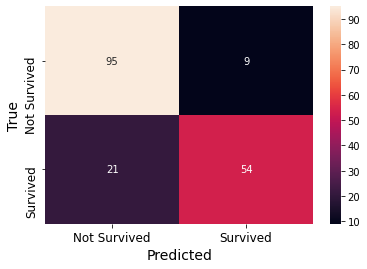

In [ ]:
#自訂義plot_confusion函數
'''
格式化繪製的圖表型態
'''
def plot_confusion(predictions):
    y_pred = predictions
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');

    ax.set_xlabel('Predicted', fontsize=14)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.set_ticklabels(['Not Survived', 'Survived'], fontsize = 12)
    ax.set_ylabel('True', fontsize=14)
    ax.yaxis.set_ticklabels(['Not Survived', 'Survived'], fontsize = 12)
    plt.show()

# Gboost
'''
梯度增加法
'''
Gboost = GradientBoostingClassifier(random_state=random_state)
Gboost_params = {
    'loss' : ['deviance'],
    'n_estimators' : [8, 10, 16, 20, 100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [100, 150],
    'max_features': [0.3, 0.1] 
}

import matplotlib.pyplot 
Gboost_gs = GridSearchCV(Gboost, param_grid=Gboost_params, refit=True, cv=kfold, scoring='accuracy', n_jobs=20)
Gboost_gs.fit(X_train,y_train)
best_Gboost = Gboost_gs.best_estimator_
predictions = best_Gboost.predict(X_test)
print('The accuracy of the Gradient Boosting: ', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
plot_confusion(predictions)

The accuracy of the KNeighbors:  0.8268156424581006
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86       104
         1.0       0.84      0.72      0.78        75

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



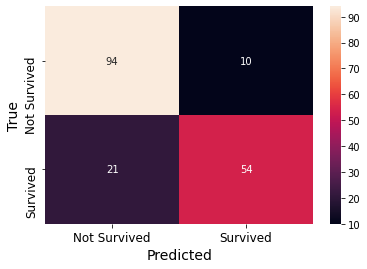

In [ ]:
# Knc
'''
近鄰分析
'''
Knc = KNeighborsClassifier()
Knc_params = {
    'n_neighbors' : np.linspace(1, 100, 100).astype('int'),
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree']
}
Knc_gs = GridSearchCV(Knc, param_grid=Knc_params, refit=True, cv=kfold, scoring='accuracy', n_jobs=20)
Knc_gs.fit(X_train,y_train)
best_Knc = Knc_gs.best_estimator_
predictions = best_Knc.predict(X_test)
print('The accuracy of the KNeighbors: ', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
plot_confusion(predictions)

The accuracy of the Extra Trees:  0.8268156424581006
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.86       104
         1.0       0.83      0.73      0.78        75

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



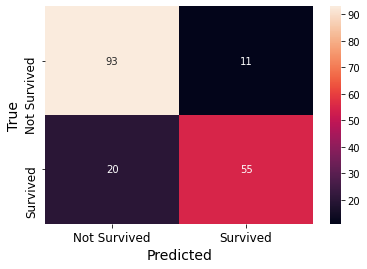

In [ ]:
#ExtraTrees 
'''
極限樹
'''
Ext_t = ExtraTreesClassifier(random_state=random_state)
Ext_t_params = {
    'max_depth' : [1, 2, 3],
    'max_features' : ['sqrt'],
    'min_samples_split' : [2, 3, 10],
    'min_samples_leaf' : [1, 3, 10],
    'bootstrap' : [False],
    'n_estimators' :[10, 20, 100, 300, 400, 500],
    'criterion' : ['gini', 'entropy']
}
Ext_t_gs = GridSearchCV(Ext_t, param_grid=Ext_t_params, refit=True, cv=kfold, scoring='accuracy', n_jobs=20)
Ext_t_gs.fit(X_train,y_train)
best_Ext_t = Ext_t_gs.best_estimator_
predictions = best_Ext_t.predict(X_test)
print('The accuracy of the Extra Trees: ', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
plot_confusion(predictions)

The accuracy of the Random Forest:  0.8156424581005587
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       104
         1.0       0.83      0.71      0.76        75

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



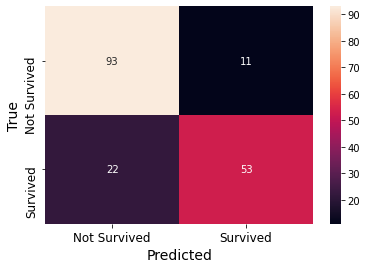

In [ ]:
# Random Forest
'''
隨機森林
'''
Rf = RandomForestClassifier(random_state=random_state)
Rf_params = {
    'max_depth': [5, 6, 7, 8],
    'max_features': [3, 4,'sqrt'],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [2, 3],
    'n_estimators' :[5, 10, 20, 80, 100, 200, 300],
    'criterion': ['gini']
}
Rf_gs = GridSearchCV(Rf, param_grid=Rf_params, refit=True, cv=kfold, scoring='accuracy', n_jobs=20)
Rf_gs.fit(X_train,y_train)
best_Rf = Rf_gs.best_estimator_
predictions = best_Rf.predict(X_test)
print('The accuracy of the Random Forest: ', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
plot_confusion(predictions)


The accuracy of the Ensemble:  0.8324022346368715
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86       104
         1.0       0.86      0.72      0.78        75

    accuracy                           0.83       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



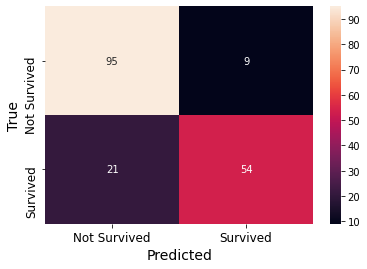

In [ ]:
#Ensemble:
'''
使用VotingClassifier函數ensemble以上4個演算法,提高精確度(其實應該要用5個避免平手?,但其他方法有點跑不動@ @)
參數:( estimators:使用的演算法,voting:有soft跟hard兩種,soft為平均每一個算法而hard為多數決, n_jobs:同時工作的cpu數)
'''
voting_clf = VotingClassifier(
    estimators = [
        ('Gboost', best_Gboost),
        ('Rf', best_Rf),
        ('Ext_t', best_Ext_t),
        ('Knc', best_Knc),
    ], voting='hard', n_jobs=20)
voting = voting_clf.fit(X_train, y_train)
predictions = voting.predict(X_test)
print('The accuracy of the Ensemble: ', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
plot_confusion(predictions)
#使用ensemble後精度比上述四種單獨算法都更高(84%)

In [ ]:
#將最終結果另存一個預測csv檔
# predict and save prediction to csv for submission
test_survived = pd.Series(voting.predict(predict).astype(int), name="Survived")
id_ = test_data['PassengerId']
results = pd.concat([id_, test_survived], axis=1)
results.to_csv("sub_prediction.csv",index=False)